Code used from this link:

https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83

GitHub Link: 
https://github.com/aditya10/ULMFiT-fastai-text-classifier/blob/master/ULMFiT_tutorial.ipynb



In [ ]:
#code needed to use colab notebook
#if you're using juptyer notebook then skip this line
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

###Model set-up

In [3]:
#cd needed for colab
#%cd "gdrive/My Drive/Colab Notebooks"
%cd ..
!ls

/Users/Rolf/Documents/GitHub/esade_fake_news/4_Politics/python3_script/data/nlp
20200504-193926_joe_biden_bias.csv
20200504-193926_joe_biden_nlp.csv
20200504-193926_joe_biden_nlp_subs.csv
20200504-193926_joe_biden_nlp_subs_clean.csv
20200504-193926_joe_biden_nlp_subs_clean_expanded.csv
notebooks
results
trigrams_joe_biden.png


In [4]:
# load train_cleaned.csv

filename = "20200504-193926_joe_biden_nlp_subs_clean_expanded.csv"
df = pd.read_csv(filename, index_col=0)

In [5]:
df.head(2)

,bias_num,text
0,0,who hasn't been shocked by a recent electricit...
1,0,ther half have it denote when it gets dark [] ...


In [6]:
#length of dataset
print(f'Length of dataset is: {len(df)}')

#percentage of videos that are right
pr_right = round(df['bias_num'].mean()*100,2)
print(f'Percentage of videos that are right: {pr_right} %')

Length of dataset is: 18362
Percentage of videos that are right: 42.04 %


In [ ]:
#combine columns. Fastai only works with 1 text column
#train_language['text'] = train_language['title'] + " " + train_language['description']

In [ ]:
#create train and test split
df_trn, df_val = train_test_split(df, stratify = df['bias_num'], test_size = 0.3, random_state=42)
df_trn.shape, df_val.shape

((12853, 2), (5509, 2))

### Pre-processing language model

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
# check out data
data_clas.show_batch()

text,target
"xxbos xxup ou xxup never xxup know . xxup right ? xxup you xxup never xxup know . xxup if xxup you xxup don \ ' t xxup have a xxup vaccine , xxup if \n xxup that xxup virus xxup is xxup gone , xxup we xxup are xxup like xxup where xxup we xxup were xxup before . > > xxup stephen : xxup oh , xxup",0
"xxbos xxup what \ xxup 's xxup wrong xxup with xxup nonsense ? > > xxup well . > > : xxup does xxup everything \n xxup have xxup to xxup be xxup true xxup to xxup you . > > xxup okay , i \ ' m a xxup catholic . > > : xxup welcome . xxup welcome xxup aboard . > > \n > >",0
"xxbos xxup re xxup is \n "" xxup boom . "" xxup trump xxup just xxup doesn \ ' t xxup talk xxup like a \n xxup guy xxup who xxup knows xxup what xxup he \ xxup 's xxup talking xxup about . xxup can xxup you xxup imagine xxup him xxup as a xxup doctor ? ( xxup as xxup trump ) \n "" xxup",0
"xxbos xxup oh , xxup folks , xxup my xxup next xxup guest xxup is a \n xxup former "" xxup the xxup daily xxup show "" xxup correspondent xxup whose xxup new xxup series \n "" xxup patriot xxup act "" xxup is xxup now xxup on xxup netflix . xxup please xxup welcome xxup hasan xxup minhaj ! ( xxup applause ) \n ♪ ♪",0
xxbos t xxup trampled xxup on . xxup get xxup trampled xxup on . \n xxup what xxup do xxup you xxup think xxup is xxup going xxup to xxup what xxup do xxup you xxup think xxup is xxup going xxup to \n xxup happen xxup with xxup that ? xxup happen xxup with xxup that ? \n > > xxup we xxup are xxup lucky,1


In [ ]:
#data_clas.save("/content/gdrive/My Drive/language_models/databunch/TextClasDataBunch.pkl") 

In [ ]:
#data_lm.save("/content/gdrive/My Drive/language_models/databunch/TextLMDataBunch.pkl")

### Language model

In [ ]:
# train language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
# let’s use this learning rate to train the language model
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.993116,4.820770,0.226649,06:03
1,4.570313,4.398626,0.255499,06:04
2,4.364091,4.247293,0.268059,06:04
3,4.223861,4.184824,0.272929,06:05
4,4.153211,4.152590,0.275437,06:06
5,4.088907,4.135224,0.277259,06:06
6,4.100654,4.125150,0.278147,06:06
7,3.993214,4.120499,0.278578,06:06
8,4.045718,4.118598,0.278682,06:06
9,4.006376,4.118268,0.278759,06:06


In [ ]:
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.882067,3.963007,0.297244,07:08
1,3.706729,3.902168,0.306523,07:08


In [ ]:
#save the language model encoder so that we can load it later in our classifier
learn.save_encoder("ft_enc")

### Classification

In [ ]:
#set-up classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy])
learn.load_encoder('ft_enc')

In [ ]:
#train classifier for 10 epochs
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.510677,0.470164,0.775458,03:32
1,0.526781,0.431749,0.797785,03:22
2,0.465358,0.414424,0.800871,03:33
3,0.447797,0.430900,0.791432,03:28
4,0.439999,0.406783,0.797967,03:27
5,0.435880,0.380689,0.817027,03:31
6,0.404246,0.398594,0.806317,03:31
7,0.406918,0.374504,0.818479,03:30
8,0.370308,0.392935,0.806862,03:28
9,0.408806,0.361935,0.826829,03:21


In [ ]:
#save model weights
#learn.save('language_classifier')

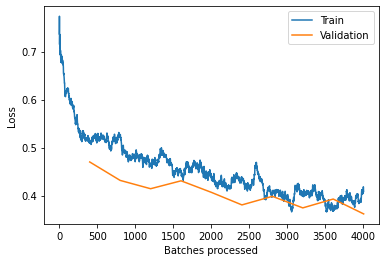

In [ ]:
#inspect losses.
learn.recorder.plot_losses()

In [ ]:
# unfreezing weights and training the rest of the NN
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.419401,0.358623,0.829733,04:00
1,0.399065,0.383998,0.823380,03:55
2,0.331135,0.332860,0.846252,04:00
3,0.275904,0.313679,0.856235,04:01


In [ ]:
#export language classifier for prediction
#learn.export(file = "nlp_export.pkl")

###Confusion matrix

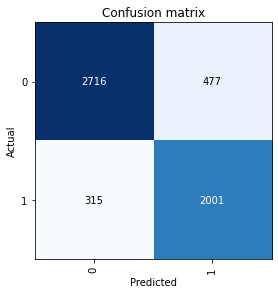

In [ ]:
# create confusion matrix
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()